# Speech Recognition using CDHMMs

In [1]:
import os
import MFCC
import re
import random

import numpy as np
from hmmlearn import hmm
from scipy.io import wavfile
from scipy.special import logsumexp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Problem 1

Write a function `sample_gmmhmm` which accepts an integer $T$, and draws $T$ samples from the GMMHMM given in the lab pdf.

Use your function to draw $T=900$ samples from the GMMHMM.
Use `sklearn.decomposition.PCA` with 2 components to plot the observations in two-dimensional space. 
Color the observations by state.
How many distinct clusters do you see?

Hint: the function `np.random.choice` will be useful for drawing the hidden states and the GMM components, and `np.random.multivariate_normal` for the observation sequence. 
When plotting the samples, using the keyword argument `c` in `plt.scatter` allows you to specify the colors of the individual points.

In [3]:
def sample_gmmhmm(T):
    """
    Simulate from the GMMHMM given in the problem, returning T samples.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    N = 3
    K = 5
    M = 4
    
    ## Define the GMMHMM parameters
    # NxN transition matrix 
    A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])
    # NxK collection of component weights
    weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], 
                        [.1, .3, .2, .1, .3]])
    # NxKxM collection of component means
    means = np.array([np.floor(np.random.uniform(-100, 100, size = (5, 4))) 
                            for i in range(3)])
    # NxKx(MxM) collection of component covariance matrices       
    covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) 
                            for i in range(5)] for j in range(3)])
    # (N,) ndarray initial state distribution 
    pi = np.array([.15, .15, .7])
    
    """     my code     """
    # initilaize observations & states
    state = np.argmax(np.random.multinomial(1, pi))
    obs = np.zeros((T, means.shape[2]))
    states = np.zeros(T)

    # iterate to get each sample component & the next state
    for i in range(T):
        sample_component = np.argmax(np.random.multinomial(1, weights[state,:]))
        sample = np.random.multivariate_normal(means[state, sample_component, :], covars[state, sample_component, :, :])
        obs[i] = sample

        # use the transition matrix to get the next state
        states[i] = state
        state = np.argmax(np.random.multinomial(1, A[state, :]))
    
    return states, obs


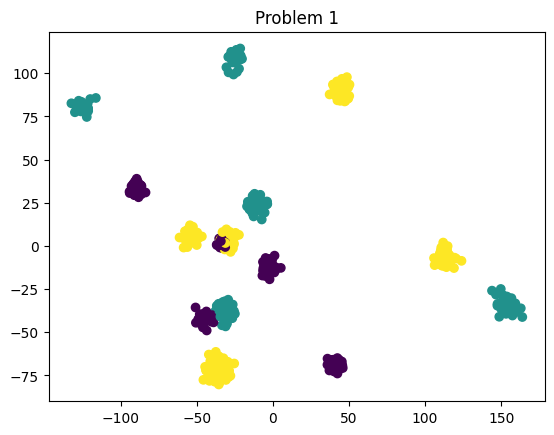

In [15]:
# sklearn.decomposition.PCA w/ 2 components 
pca = PCA(n_components=2)
states, obs = sample_gmmhmm(900)
data = pca.fit_transform(obs)

# plot
plt.scatter(data[:,0], data[:,1], c=states)
plt.title('Problem 1')
plt.show()

## Problem 2

In the remainder of this lab, we will create a speech recognition system for the vocabulary of the following five words/phrases: "biology", "mathematics", "political science", "psychology", and "statistics".

The `Samples` folder contains 30 recordings for each of the words/phrases in the vocabulary.
These audio samples are 2 seconds in duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed integers in WAV format. 
For each of the words, create a list holding the MFCC coefficients of the recordings of that word.

The function `scipy.io.wavfile.read` can be used to load the sound files, and the function `extract` in `MFCC.py` implements the MFCC coefficient algorithm.

In [ ]:
# initialize 
filenames = ["Biology", "Mathematics", "PoliticalScience", "Psychology", "Statistics"]
mfcc_coefs = [[] for i in range(5)]

# iterate through each file
for file in os.listdir('Samples/'):
    for i in range(5):
        if file.startswith(filenames[i]):

            # read file from the samples folder
            samplerate, sound_data = wavfile.read('Samples/' + file)
            
            # load the wavfile
            model = MFCC.extract(data)
            coefficients = MFCC.extract(sound_data)
            mfcc_coefs[i].append(coefficients)

## Problem 3

For each word, randomly split the list of MFCCs into a training set of 20 samples and a test set of the remaining 10 samples.

Use the training sets to train GMMHMMs on each word in the vocabulary.
For each word in the vocabulary, train 10 GMMHMMs on the training set, using `n_components=5`.
Keep the model with the highest log-likelihood for each word.

In [19]:
# helper function
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += np.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + np.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

# initialize
train_samples, test_samples = {}, {}

# iterate
for i in range(5):
    train_samples[filenames[i]], test_samples[filenames[i]] = train_test_split(mfcc_coefs[i], test_size=0.33, random_state=42)

# initialize pt 2
models, log_likes, best_models = [[] for i in range(5)], [[] for j in range(5)], []

# iterate pt 2
for j, word in enumerate(filenames):
    for i in range(10):
        # reshape data to work with hmmlearn's fit method
        data = train_samples[word]
        lengths = [data[0].shape[0]] * len(data)
        data_collected = np.vstack(data)

        # get the probs and transition matrices & build the model
        startprob, transmat = initialize(5)
        model = hmm.GMMHMM(n_components=5, covariance_type="diag",
                                init_params="mc")
        models[j].append(model)

        # probabilities and transition matrices
        model.startprob_ = startprob
        model.transmat_ = transmat

        # fit the model
        model.fit(data_collected)

        # calc log-likelihoood 
        log_like = model.monitor_.history[-1]
        log_likes[j].append(log_like)

        if i == 9:
            best_log_like = np.argmax(np.array(log_likes[j]))
            best_models.append(models[j][best_log_like])

## Problem 4

Write a `predict` function for your speech recognition model.
In this function:
 - Accept the MFCC coefficients of the speech sample to be predicted.
 - Find the log probability density of the coefficients for each word's GMMHMM.
 - Return the word with the highest probability as the speech recognition model's prediction.

In [20]:
def predict(weights):
    # initialize
    scores = []
    # iterate
    for model in best_models:
        scores.append(model.score(weights))
    return np.argmax(scores)

## Problem 5

For each of the five test sets, call your `predict` function on each sample, and find the proportion of each test set that your model predicts correctly.
Display your results.
How well does your model perform on this dataset?

In [21]:
# iterate through each label, predict & see how many are correct
accuracies = {}
for j, word in enumerate(filenames):
    accuracy = 0
    for test_set in test_samples[word]:
        prediction = predict(test_set)
        if j == prediction:
            accuracy += 1
    accuracies[word] = accuracy/10

# print accuracies
print(accuracies)


{'Biology': 1.0, 'Mathematics': 1.0, 'PoliticalScience': 1.0, 'Psychology': 1.0, 'Statistics': 1.0}
